In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [316]:
df=pd.read_excel('PassEventsForwardFootball.xlsx')

In [317]:
# --------------------------------------------------------- observe

# conclusion: from the sorted TimeStamp, I found that there are two matches rather than two teams in one match-> more obvious, day is different->done

df_team_one=df[df.Team=="Team Forward Football_1"]
df_team_two=df[df.Team=="Team Forward Football_2"]

# df_team_one.sort_values('TimeStamp') # check the starting and ending time of each team



In [318]:
# df_team_two.sort_values('TimeStamp')

# *********************************************************

In [319]:
# ---------------------------------------------------------

# df.groupby(['Player_id']).size() 

# calculate this in order to make sure there is no player with just a single line data
# -> avoid when splitting dataset, there is no solution to split into training and test dataset
# -> the result is positive-> done

# *********************************************************

In [320]:
# ---------------------------------------------------------
def print_column_name(df):
    for col in df:
        print("column name:",col)
# print_column_name(df)


# feature expansion
# 1. this is obvious that the distance between passer and receicver has the influence on if the pass is successful
# -> found that Pass length has been calculated->done
# -> but angle of start is also informative-> angle is also calculated->done
# 2. the difference between startTime and the start time have an influence on the physical strength-> done
# 3. if the exact position or the interval of position has an influence on the result-> generate features,check the correlation-> how to use it ??? we have automately feature selection

# 4. note that former part is more team 1, later part is for team 2, then there is also the overlap records, try to use time to generate features !!!
# time can also use Time block, or calculated time using minus
# -> how many opponents appear in 5s in a exact scope
# -> how many friends appear in 5s or around 5s in a exact score
# -> how many rival passes
# -> how many friends passes 
# -> how many rivals and friends in a certain fields.

# 5. Angle passe is for ridian, maybe degree is better ???-> not sure,but don't think so, just leave this idea here ==

# about time period for the first match and second match or not? -> just two matches->done

# consider the success rate of pass of one player-> should done after split->done

# outlier?-> not in this project

In [321]:
# the scale is for per second, we don't need to extract more
# just have two matches, not periodic, so not informatie-> discard ???

df['pass_year']=pd.DatetimeIndex(df['TimeStamp']).year
df['pass_month']=pd.DatetimeIndex(df['TimeStamp']).month
df['pass_day']=pd.DatetimeIndex(df['TimeStamp']).day
df['pass_hour']=pd.DatetimeIndex(df['TimeStamp']).hour
df['pass_minute']=pd.DatetimeIndex(df['TimeStamp']).minute
df['pass_second']=pd.DatetimeIndex(df['TimeStamp']).second


In [322]:
df['start_year']=pd.DatetimeIndex(df['startTime']).year
df['start_month']=pd.DatetimeIndex(df['startTime']).month
df['start_day']=pd.DatetimeIndex(df['startTime']).day
df['start_hour']=pd.DatetimeIndex(df['startTime']).hour
df['start_minute']=pd.DatetimeIndex(df['startTime']).minute
df['start_second']=pd.DatetimeIndex(df['startTime']).second

In [323]:
df['time_process']=pd.DatetimeIndex(df['TimeStamp'])-pd.DatetimeIndex(df['startTime'])

In [324]:
# df['time_process']

# note that there is no month or year, so
# df['time_process_year']=df['time_process'].dt.components.years
# df['time_process_month']=df['time_process'].dt.components.months
# is not needed at all

In [325]:
df['time_process_day']=df['time_process'].dt.components.days
df['time_process_hour']=df['time_process'].dt.components.hours
df['time_process_minute']=df['time_process'].dt.components.minutes
df['time_process_second']=df['time_process'].dt.components.seconds

In [326]:
def drop_columns(df,lst_columns):
    return df.drop(columns=lst_columns,axis=1)
def drop_columns_with_one_unique_value(df):
    return drop_columns(df,get_columns_with_one_unique_value(df))

def get_columns_with_one_unique_value(df):
    col_counts = df.nunique()
    cols_with_one_unique_value = col_counts[col_counts == 1]
    return list(cols_with_one_unique_value.index)

In [327]:

# there will be a lot of columns that are not informative( just have one unique value), then check how many here
# get_columns_with_one_unique_value(df)

In [328]:

def print_unique_value(df):
    for col in df:
        print("column name:",col)
        print(df[col].unique())
        print("---")
# print_unique_value(df)

# from the result, we could see that columns
# Type, x_pitchsize, y_pitchsize each have just one unique value->done
# Club has just one unique vale ['Team Forward Football']-> done


# isForward and isSucceeded are either True or False, then convert them to numerical value 0 and 1 in order to better process-> done
# Team is either ['Team Forward Football_1' 'Team Forward Football_2'], then convert them to numerical value 0 and 1 -> done
# Pass type ['Forward pass' 'Lateral pass' 'Backward pass']-> 0,1,2->done
# Pressure level -> ['Full Pressure' 'No Pressure' 'Limited Pressure']->done
# column name: Zone ['Attack' 'Defence' 'Mid field']->0,1,2
# column name: Playing direction_first half
# ['left' 'right']
# column name: Playing direction_second half
# ['left' 'right']

# matchDuration is written in minutes and also just have two values-> don't need to convert



In [329]:
df.isForward = df.isForward.replace({True: 1, False: 0})
df.isSucceeded = df.isSucceeded.replace({True: 1, False: 0})
df.Team=df.Team.replace({'Team Forward Football_1':0,'Team Forward Football_2':1}) # first team 1-> number 1,but seems that it's better to have classified value begin from 0
df['Pass type']=df['Pass type'].replace({"Forward pass":0,"Lateral pass":1,"Backward pass":2})
df['Pressure level']=df['Pressure level'].replace({"Full Pressure":2,"Limited Pressure":1,"No Pressure":0})
df['Zone']=df['Zone'].replace({'Attack':0,'Defence':1,'Mid field':2})
df['Playing direction_first half']=df['Playing direction_first half'].replace({'left':0,'right':1})
df['Playing direction_second half']=df['Playing direction_second half'].replace({'left':0,'right':1})


In [330]:
# --------------------------------------------------------- for test
# generate features based on groupby Player_id

# df.groupby(['Player_id'])['isSucceeded'].mean().reset_index(name='mean_isSucceeded_each_player')


In [331]:
def get_none_percent(df):
    return df.isna().sum()/df.shape[0]
def get_none_num(df):
    return df.isna().sum()

# get_none_percent(df)


In [332]:
def compute_lenght(df):
    import math
    length=np.sqrt((df['posX_passer']-df['received_PosX'])**2+(df['posY_passer']-df['received_PosY'])**2)
    return length

In [333]:
fill_series=compute_lenght(df)

In [334]:
# df["Pass length"]=df["Pass length"].fillna(compute_lenght(df)) # actually it's not allowed, will fill in with a function not the return value of this function
df["Pass length"]=df["Pass length"].fillna(fill_series)

In [335]:
# found that there is no receivedId if isSucceed is false, check if they have the one-to-one relation
# -> the answer is yes, so receivedId is also the answer!!! we can't use it in training a model
# -> just delete it (receivedId)->done

# 1-df['isSucceeded'].sum()/df.shape[0]

# even the pass is not successful, then there is a expected sending point and a received point, so all the Pass length could be calculated
# -> the missing value of Pass length is solved-> done



In [336]:
# considering about the imbalance of isSucceeded

# print("successful:",df['isSucceeded'].sum()/df.shape[0])
# print("failure:",1-df['isSucceeded'].sum()/df.shape[0])

# -> not so balanced
# -> so try to interpolate the minor class or reduce the major class or using another score metric *** different choice
# -> which is suitable? but imbalanced data is not series, so tring score metric, for example, f1 score


In [337]:
import math
def get_degree(ridian):
    return ridian/math.pi*180
def get_ridian(degree):
    return degree*math.pi/180

In [338]:
# Define a custom function that returns the data type of a column
def check_dtype(col):
    return col.dtype
    
# Apply the custom function to each column of the DataFrame
# df.apply(check_dtype)

In [303]:
lst_delete=['TimeStamp','startTime','time_process'] # receivedId is also informative, so don't delete it, 'time_process' is discarded, just two match, not informative->done
lst_one_value=get_columns_with_one_unique_value(df)
# print(lst_one_value)


In [304]:
df=drop_columns(df,lst_delete+lst_one_value)

In [305]:
df.receiverId

0       95583.0
1       95601.0
2       95597.0
3       95587.0
4       95579.0
         ...   
1137    95583.0
1138    95601.0
1139    95617.0
1140    95603.0
1141    95986.0
Name: receiverId, Length: 1142, dtype: float64

In [306]:
def get_distribution_of_each_column(df):
    # Loop over the features
    for col in df:
        # Select the feature
        feature = df[col]
        
        # Plot the distribution of the feature
        sns.histplot(feature)
        plt.show()

def get_distribution_columns(df,col_lst):
    # Loop over the features
    for col in col_lst:
        # Select the feature
        feature = df[col]
        
        # Plot the distribution of the feature
        sns.histplot(feature)
        plt.show()
# get_distribution_of_each_column(df) 
# found that Pass length and Distance to first oppoment have log distribution

In [307]:
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(output_distribution='normal')
df['Pass length'] = transformer.fit_transform(df['Pass length'].values.reshape(-1,1))
df['Distance to first opponent'] = transformer.fit_transform(df['Distance to first opponent'].values.reshape(-1,1))

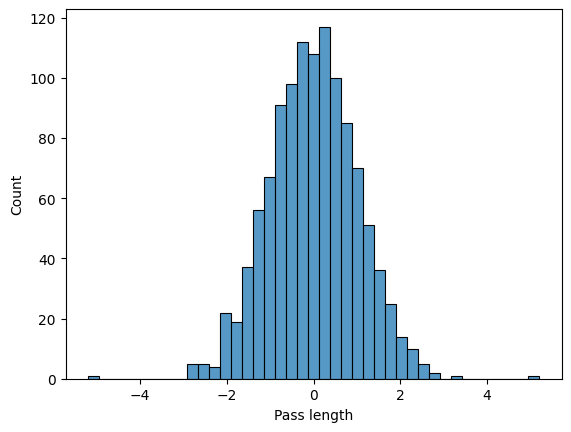

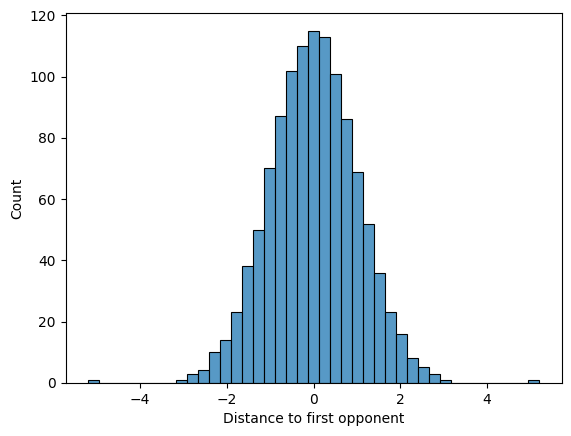

In [308]:
get_distribution_columns(df,['Pass length','Distance to first opponent']) # found that normal distribution has been transformed successfully

In [309]:
df

,posX_passer,posY_passer,received_PosX,received_PosY,isForward,isSucceeded,receiverId,Player_id,Team,matchDuration,...,pass_day,pass_hour,pass_minute,pass_second,start_day,start_hour,start_minute,time_process_hour,time_process_minute,time_process_second
0,32,58,26,55,1,1,95583.0,95582,0,66.221867,...,5,11,39,15,5,11,36,0,3,2
1,16,23,20,29,0,1,95601.0,95582,0,66.221867,...,5,11,39,59,5,11,36,0,3,46
2,92,56,68,52,1,1,95597.0,95582,0,66.221867,...,5,11,41,47,5,11,36,0,5,34
3,72,55,76,62,0,1,95587.0,95582,0,66.221867,...,5,11,45,55,5,11,36,0,9,42
4,74,53,83,50,0,1,95579.0,95582,0,66.221867,...,5,11,46,1,5,11,36,0,9,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,3,8,9,9,0,1,95583.0,95597,1,61.157933,...,12,12,51,49,12,12,6,0,45,36
1138,4,12,14,47,0,1,95601.0,95597,1,61.157933,...,12,12,51,52,12,12,6,0,45,39
1139,35,48,35,40,0,1,95617.0,95597,1,61.157933,...,12,12,52,37,12,12,6,0,46,24
1140,47,58,47,59,0,1,95603.0,95597,1,61.157933,...,12,12,53,57,12,12,6,0,47,44


In [310]:
# generate bin values
num_bins = 4
df['angle_bins'] = pd.qcut(df['Angle Passe'], num_bins)

In [311]:
lst=df['angle_bins'].unique()
my_dic={}
my_dict = {}
for i, val in enumerate(lst):
    my_dict[val] = i

In [312]:
df.angle_bins = df.angle_bins.replace(my_dict)

In [313]:
# Save the DataFrame to a CSV file
df.to_csv("generated_data.csv")